In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

In [42]:
raw_data = pd.read_csv("test_scores.csv",)
raw_data.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [43]:
f_data = raw_data.loc[:,~raw_data.columns.isin({"school","classroom","student_id"})].copy()
f_data.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest
0,Urban,Non-public,Standard,20.0,Female,Does not qualify,62.0,72.0
1,Urban,Non-public,Standard,20.0,Female,Does not qualify,66.0,79.0
2,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0
3,Urban,Non-public,Standard,20.0,Female,Does not qualify,61.0,77.0
4,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0


In [44]:
for col in f_data.columns:
    if (f_data[col].dtype == "object"):
        f_data[col] = f_data[col].astype('category')


In [45]:
f_data.posttest.describe().to_frame()


,posttest
count,2133.000000
mean,67.102203
std,13.986789
min,32.000000
25%,56.000000
50%,68.000000
75%,77.000000
max,100.000000


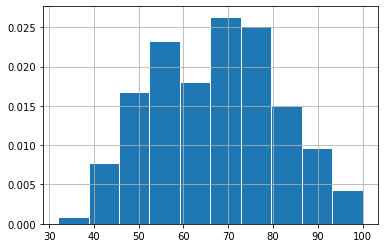

In [46]:
f_data.posttest.hist(density=True,edgecolor = 'white')
plt.show()

In [47]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=10)
(pd.crbinned_gradschool_settinges,f_data.school_type,normalize="columns")*100).round(1)

school_type,Non-public,Public
binned_grades,,
"(31.932, 38.8]",0.0,0.8
"(38.8, 45.6]",0.2,7.0
"(45.6, 52.4]",3.3,14.3
"(52.4, 59.2]",6.5,19.1
"(59.2, 66.0]",4.5,17.3
"(66.0, 72.8]",15.8,16.3
"(72.8, 79.6]",31.4,12.1
"(79.6, 86.4]",26.1,4.7
"(86.4, 93.2]",7.8,6.1


In [52]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=10)
(pd.crosstab(f_data.binned_grades,f_data.teaching_method,normalize="columns")*100).round(1)

teaching_method,Experimental,Standard
binned_grades,,
"(31.932, 38.8]",0.0,0.9
"(38.8, 45.6]",1.4,7.4
"(45.6, 52.4]",8.4,13.1
"(52.4, 59.2]",12.1,17.9
"(59.2, 66.0]",6.8,17.9
"(66.0, 72.8]",14.1,17.3
"(72.8, 79.6]",22.0,14.3
"(79.6, 86.4]",17.9,6.0
"(86.4, 93.2]",12.2,3.4


In [53]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=10)
(pd.crosstab(f_data.binned_grades,f_data.gender,normalize="columns")*100).round(1)

gender,Female,Male
binned_grades,,
"(31.932, 38.8]",0.6,0.6
"(38.8, 45.6]",4.7,5.8
"(45.6, 52.4]",12.6,10.3
"(52.4, 59.2]",16.9,14.9
"(59.2, 66.0]",12.9,15.0
"(66.0, 72.8]",16.0,16.3
"(72.8, 79.6]",15.8,18.3
"(79.6, 86.4]",11.3,9.2
"(86.4, 93.2]",6.5,6.6


In [54]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=10)
(pd.crosstab(f_data.binned_grades,f_data.school_setting,normalize="columns")*100).round(1)

school_setting,Rural,Suburban,Urban
binned_grades,,,
"(31.932, 38.8]",1.2,0.0,0.7
"(38.8, 45.6]",10.0,0.0,6.7
"(45.6, 52.4]",6.7,1.0,22.4
"(52.4, 59.2]",18.6,6.8,21.4
"(59.2, 66.0]",12.4,12.1,16.3
"(66.0, 72.8]",23.1,18.4,10.5
"(72.8, 79.6]",20.0,24.3,9.7
"(79.6, 86.4]",7.6,16.0,7.1
"(86.4, 93.2]",0.4,16.0,2.5


In [55]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=10)
(pd.crosstab(f_data.binned_grades,f_data.lunch,normalize="columns")*100).round(1)

lunch,Does not qualify,Qualifies for reduced/free lunch
binned_grades,,
"(31.932, 38.8]",0.0,1.3
"(38.8, 45.6]",0.2,12.0
"(45.6, 52.4]",1.5,24.6
"(52.4, 59.2]",8.9,25.1
"(59.2, 66.0]",15.2,12.3
"(66.0, 72.8]",19.0,12.4
"(72.8, 79.6]",22.7,9.6
"(79.6, 86.4]",16.0,2.5
"(86.4, 93.2]",11.4,0.2


In [56]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=10)
(pd.crosstab(f_data.binned_grades,f_data.n_student,normalize="columns")*100).round(1)

n_student,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0
binned_grades,,,,,,,,,,,,,,,,,,
"(31.932, 38.8]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,1.4,0.7,0.0,0.0,0.0,3.0,0.0,0.0,0.0
"(38.8, 45.6]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.8,9.4,27.1,4.0,0.0,0.0,13.7,3.4,8.7,0.0
"(45.6, 52.4]",0.0,0.0,1.6,0.0,8.3,3.8,1.9,1.3,4.5,5.8,17.4,42.4,7.7,1.6,0.0,65.5,66.0,16.1
"(52.4, 59.2]",0.0,0.0,14.1,0.0,15.3,9.8,18.8,6.9,22.3,0.0,14.6,12.8,76.9,29.6,10.7,27.6,25.3,74.2
"(59.2, 66.0]",0.0,4.4,10.9,0.0,1.4,6.8,20.0,10.8,20.5,8.7,9.0,0.8,15.4,37.6,37.5,3.4,0.0,9.7
"(66.0, 72.8]",14.3,24.4,31.2,2.9,1.4,33.1,19.4,24.7,20.1,25.4,11.8,0.8,0.0,15.9,22.0,0.0,0.0,0.0
"(72.8, 79.6]",67.9,51.1,17.2,30.9,20.8,26.3,27.5,27.7,7.2,14.5,6.9,15.2,0.0,11.1,13.1,0.0,0.0,0.0
"(79.6, 86.4]",17.9,20.0,12.5,44.9,29.2,6.0,10.6,10.0,9.5,8.0,11.8,4.0,0.0,4.2,0.0,0.0,0.0,0.0
"(86.4, 93.2]",0.0,0.0,12.5,8.8,19.4,12.8,1.9,10.0,7.2,20.3,0.7,12.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
data = f_data.copy()
categories = dict()
for col in data.columns:
    if str(data[col].dtype) != "category":
        continue
    if len(cats := data[col].cat.categories) == 2:
        categories[col] = {cats[0]:-1,cats[1]:1}
    else:
        categories[col] = {cats[i]:i for i in range(len(cats))}
    data[col] = data[col].apply(lambda x: categories[col][x])
print(categories)
data.head()

{'school_setting': {'Rural': 0, 'Suburban': 1, 'Urban': 2}, 'school_type': {'Non-public': -1, 'Public': 1}, 'teaching_method': {'Experimental': -1, 'Standard': 1}, 'gender': {'Female': -1, 'Male': 1}, 'lunch': {'Does not qualify': -1, 'Qualifies for reduced/free lunch': 1}, 'binned_grades': {Interval(31.932, 38.8, closed='right'): 0, Interval(38.8, 45.6, closed='right'): 1, Interval(45.6, 52.4, closed='right'): 2, Interval(52.4, 59.2, closed='right'): 3, Interval(59.2, 66.0, closed='right'): 4, Interval(66.0, 72.8, closed='right'): 5, Interval(72.8, 79.6, closed='right'): 6, Interval(79.6, 86.4, closed='right'): 7, Interval(86.4, 93.2, closed='right'): 8, Interval(93.2, 100.0, closed='right'): 9}}


,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,binned_grades
0,2,-1,1,20.0,-1,-1,62.0,72.0,5
1,2,-1,1,20.0,-1,-1,66.0,79.0,6
2,2,-1,1,20.0,1,-1,64.0,76.0,6
3,2,-1,1,20.0,-1,-1,61.0,77.0,6
4,2,-1,1,20.0,1,-1,64.0,76.0,6


In [64]:
data

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,binned_grades
0,2,-1,1,20.0,-1,-1,62.0,72.0,5
1,2,-1,1,20.0,-1,-1,66.0,79.0,6
2,2,-1,1,20.0,1,-1,64.0,76.0,6
3,2,-1,1,20.0,-1,-1,61.0,77.0,6
4,2,-1,1,20.0,1,-1,64.0,76.0,6
...,...,...,...,...,...,...,...,...,...
2128,2,1,1,30.0,-1,-1,39.0,55.0,3
2129,2,1,1,30.0,-1,1,38.0,46.0,2
2130,2,1,1,30.0,-1,1,45.0,51.0,2
2131,2,1,1,30.0,1,1,46.0,53.0,3


In [62]:

r_data = data.sample(frac=1, random_state=13077, ignore_index=True).drop(columns=["binned_grades"])
# Separa o df em train e test, com teste de 1/3
train, test =(r_data.iloc[:1000].copy(), r_data.iloc[1000:].copy())
tree = DecisionTreeRegressor()
tree.fit(train.drop(columns=["posttest"]),train.posttest)
test["prediction"] = tree.predict(test.drop(columns=["posttest"]))
test.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,prediction
1000,1,1,1,27.0,1,1,52.0,65.0,62.75
1001,1,1,-1,23.0,-1,-1,79.0,94.0,92.50
1002,0,1,1,19.0,-1,-1,62.0,73.0,73.00
1003,2,1,-1,24.0,1,-1,53.0,71.0,70.00
1004,2,1,1,25.0,-1,1,35.0,52.0,53.00


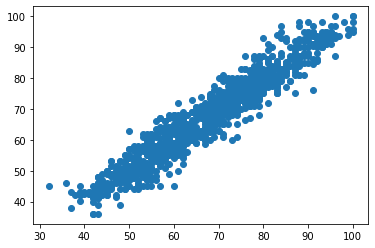

In [63]:
plt.scatter(test.posttest,test.prediction)
plt.show()